In [121]:
# Import dependencies
import pandas as pd
import scipy.stats as st
from scipy import optimize
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import requests
from census import Census
from config import api_key
from sklearn.preprocessing import PolynomialFeatures

In [122]:
# Prepare the dataset for analysis
# Read in csv file
file_path = "Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age__Provisional_2020-2023.csv"
inital_df = pd.read_csv(file_path)

# Drop the unwanted columns.
inital_df = inital_df.drop(columns=['Data As Of', 'Start Date', 'End Date', 'ICD10_codes', 'Number of Mentions', 'Flag'])

# Only keep the rows where the Group is "By Month", and delete the row where Age Group is "All Ages"
inital_df = inital_df.loc[inital_df['Group'] == 'By Month']
clean_df = inital_df.loc[inital_df['Age Group'] != 'All Ages']

# Drop the NaN values
clean_df = clean_df.dropna()

# Convert Year and Month columns to integers
clean_df.loc[:, 'Year'] = clean_df['Year'].astype(int)
clean_df.loc[:, 'Month'] = clean_df['Month'].astype(int)
clean_df.loc[:, 'COVID-19 Deaths'] = clean_df['COVID-19 Deaths'].astype(int)

clean_df.head()

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
62100,By Month,2020,1,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62101,By Month,2020,2,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62102,By Month,2020,3,United States,Respiratory diseases,Influenza and pneumonia,0-24,9
62103,By Month,2020,4,United States,Respiratory diseases,Influenza and pneumonia,0-24,27
62104,By Month,2020,5,United States,Respiratory diseases,Influenza and pneumonia,0-24,19


# Calculate the Correlation Between Public Transit and Death Rate for 2020

In [123]:
#DF 2020
year = 2020 
values_to_drop = ['United States', 'New York', 'Puerto Rico']
clean_df = clean_df.drop(clean_df[clean_df['State'].isin(values_to_drop)].index)
df_year = clean_df[clean_df['Year'] == year]
grouped = df_year.groupby('State')['COVID-19 Deaths'].sum()
df_grouped = pd.DataFrame({'State': grouped.index, 'COVID-19 Deaths': grouped.values})
df_grouped = df_grouped.sort_values('COVID-19 Deaths', ascending = False)

df_grouped.head()

,State,COVID-19 Deaths
4,California,135969
43,Texas,127240
9,Florida,85539
32,New York City,66448
30,New Jersey,64704


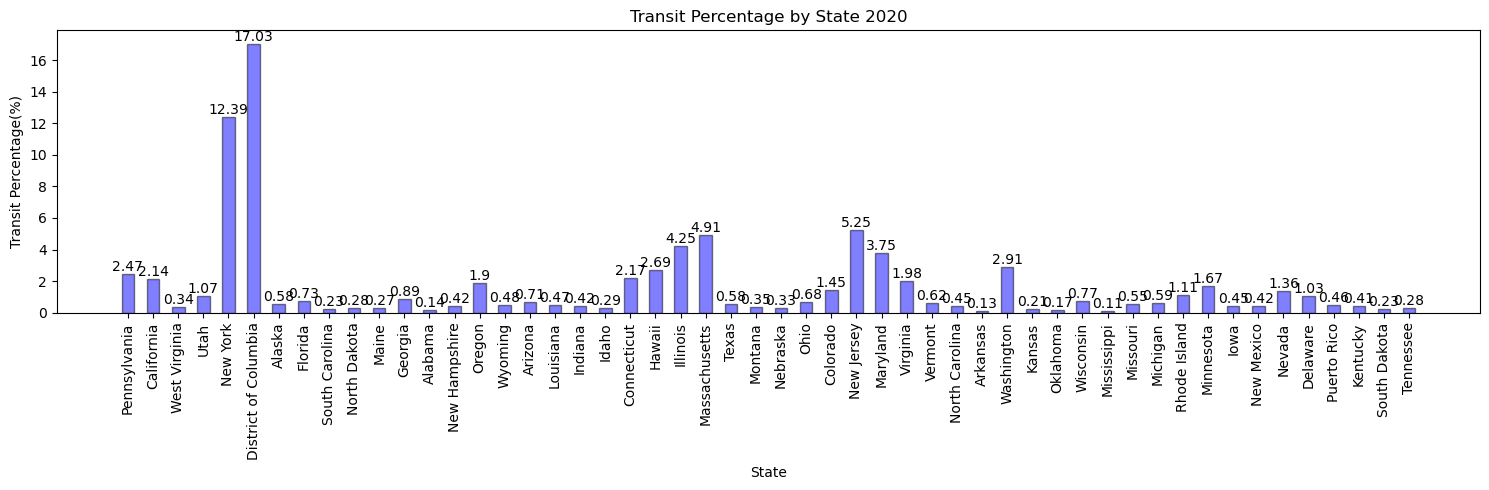

In [124]:
#fetch the population by state using Census API for 2020
c = Census(api_key, year=2020)
census_data_population = c.acs5.get(("NAME", "B01003_001E"), {'for': 'state:*'})
census_data_population = pd.DataFrame(census_data_population)
#renme the columns
census_data_population = census_data_population.rename(columns={"B01003_001E": "Population", "NAME": "State"})
census_data_population.head()

#fetch the transit_public_transport by state using Census API for 2020, 2021, 2022, and 2023
c = Census(api_key, year=2020)
census_data_transit = c.acs5.get(("NAME", "B08301_010E"), {'for': 'state:*'})
census_data_transit = pd.DataFrame(census_data_transit)
#rename the columns
census_data_transit = census_data_transit.rename(columns={"B08301_010E": "Transit", "NAME": "State"})
census_data_transit.head()

# Merge the two dataframes on state
merged_df = pd.merge(census_data_population, census_data_transit, how = "right", on="State")

# Drop the unwanted columns.
merged_df = merged_df.drop(columns=['state_x', 'state_y'])
merged_df.head()

#calculate the transit percentage using transit/population
merged_df['Transit Percentage(%)'] = (merged_df['Transit']/merged_df['Population'])*100
merged_df.head()

#plot the transit percentage by State
plt.figure(figsize=(15, 5))
plt.bar(merged_df['State'], merged_df['Transit Percentage(%)'], color='b', alpha=0.5, align="center", width=0.5, edgecolor='black')
plt.xticks(rotation=90)
plt.title("Transit Percentage by State 2020")
plt.xlabel("State")
plt.ylabel("Transit Percentage(%)")
plt.tight_layout()

#make number tags on top of each bar
for index, value in enumerate(merged_df['Transit Percentage(%)']):
    plt.text(index, value, str(round(value, 2)), horizontalalignment='center', verticalalignment='bottom')

#make the plot look better
plt.tight_layout()
plt.savefig("figs/Transit Percentage by State 2020.png")
plt.show()


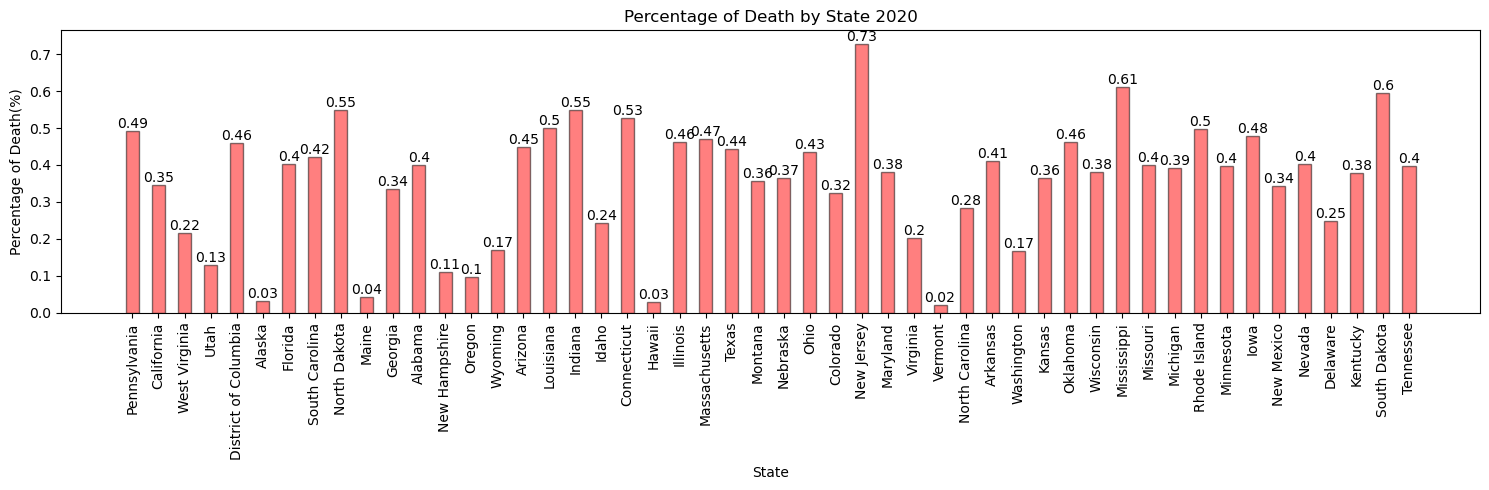

In [125]:
#merge the df_grouped and the census_data_population on state
percentage_death = pd.merge(df_grouped, census_data_population, how = "right", on="State")
percentage_death=percentage_death.drop(columns=['state'])
percentage_death.head()

#calculate the percentage of death using covid-19 deaths/population
percentage_death['Percentage of Death(%)'] = (percentage_death['COVID-19 Deaths']/percentage_death['Population'])*100
percentage_death=percentage_death.dropna()
percentage_death.head()

#plot the percentage of death by state
plt.figure(figsize=(15, 5))
plt.bar(percentage_death['State'], percentage_death['Percentage of Death(%)'], color='r', alpha=0.5, align="center", width=0.5, edgecolor='black')
plt.xticks(rotation=90)
plt.title("Percentage of Death by State 2020")
plt.xlabel("State")
plt.ylabel("Percentage of Death(%)")
plt.tight_layout()

#make number tags on top of each bar
for index, value in enumerate(percentage_death['Percentage of Death(%)']):
    plt.text(index, value, str(round(value, 2)), horizontalalignment='center', verticalalignment='bottom')

#make the plot look better
plt.tight_layout()
plt.savefig("figs/Percentage of Death by State 2020.png")
plt.show()



In [126]:
#combine the transit percentage and the percentage of death into a new dataframe
transit_percentage_death = pd.merge(merged_df, percentage_death, how = "right", on="State")
transit_percentage_death=transit_percentage_death.drop(columns=['Population_y','Population_x','COVID-19 Deaths','Transit', 'COVID-19 Deaths'])
#drop the nan values
transit_percentage_death = transit_percentage_death.dropna()

The correlation between both factors is 0.14


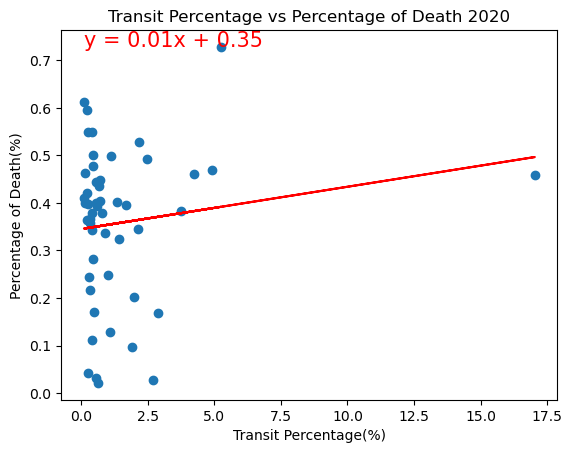

In [127]:


#establish the correlation between transit percentage and percentage of death
correlation = st.pearsonr(transit_percentage_death['Transit Percentage(%)'], transit_percentage_death['Percentage of Death(%)'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

#calulate the linear regression
x_values = transit_percentage_death['Transit Percentage(%)']
y_values = transit_percentage_death['Percentage of Death(%)']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

#add the equation and line to plot
plt.annotate(line_eq, (min(x_values), max(y_values)), fontsize=15, color="red")
plt.title('Transit Percentage vs Percentage of Death 2020')
plt.xlabel('Transit Percentage(%)')
plt.ylabel('Percentage of Death(%)')
plt.savefig("figs/Transit Percentage vs Percentage of Death 2020.png")
plt.show()


# Calculate the Correlation Between Public Transit and Death Rate for 2021

In [128]:
#fetch the population by state using Census API for 2021
c = Census(api_key, year=2021)
census_data_population = c.acs5.get(("NAME", "B01003_001E"), {'for': 'state:*'})
census_data_population = pd.DataFrame(census_data_population)
#renme the columns
census_data_population = census_data_population.rename(columns={"B01003_001E": "Population", "NAME": "State"})
census_data_population.head()


,State,Population,state
0,Alabama,4997675.0,01
1,Alaska,735951.0,02
2,Arizona,7079203.0,04
3,Arkansas,3006309.0,05
4,California,39455353.0,06


In [129]:
#fetch the transit_public_transport by state using Census API for 2021
c = Census(api_key, year=2021)
census_data_transit = c.acs5.get(("NAME", "B08301_010E"), {'for': 'state:*'})
census_data_transit = pd.DataFrame(census_data_transit)
#rename the columns
census_data_transit = census_data_transit.rename(columns={"B08301_010E": "Transit", "NAME": "State"})
census_data_transit.head()

,State,Transit,state
0,Alabama,7097.0,01
1,Alaska,4139.0,02
2,Arizona,44037.0,04
3,Arkansas,3748.0,05
4,California,743816.0,06


In [130]:

# Merge the two dataframes on state
merged_df = pd.merge(census_data_population, census_data_transit, how = "right", on="State")

# Drop the unwanted columns.
merged_df = merged_df.drop(columns=['state_x', 'state_y'])
merged_df.head()

,State,Population,Transit
0,Alabama,4997675.0,7097.0
1,Alaska,735951.0,4139.0
2,Arizona,7079203.0,44037.0
3,Arkansas,3006309.0,3748.0
4,California,39455353.0,743816.0


In [131]:
#calculate the transit percentage using transit/population
merged_df['Transit Percentage(%)'] = (merged_df['Transit']/merged_df['Population'])*100
merged_df.head()

,State,Population,Transit,Transit Percentage(%)
0,Alabama,4997675.0,7097.0,0.142006
1,Alaska,735951.0,4139.0,0.562402
2,Arizona,7079203.0,44037.0,0.622062
3,Arkansas,3006309.0,3748.0,0.124671
4,California,39455353.0,743816.0,1.885209


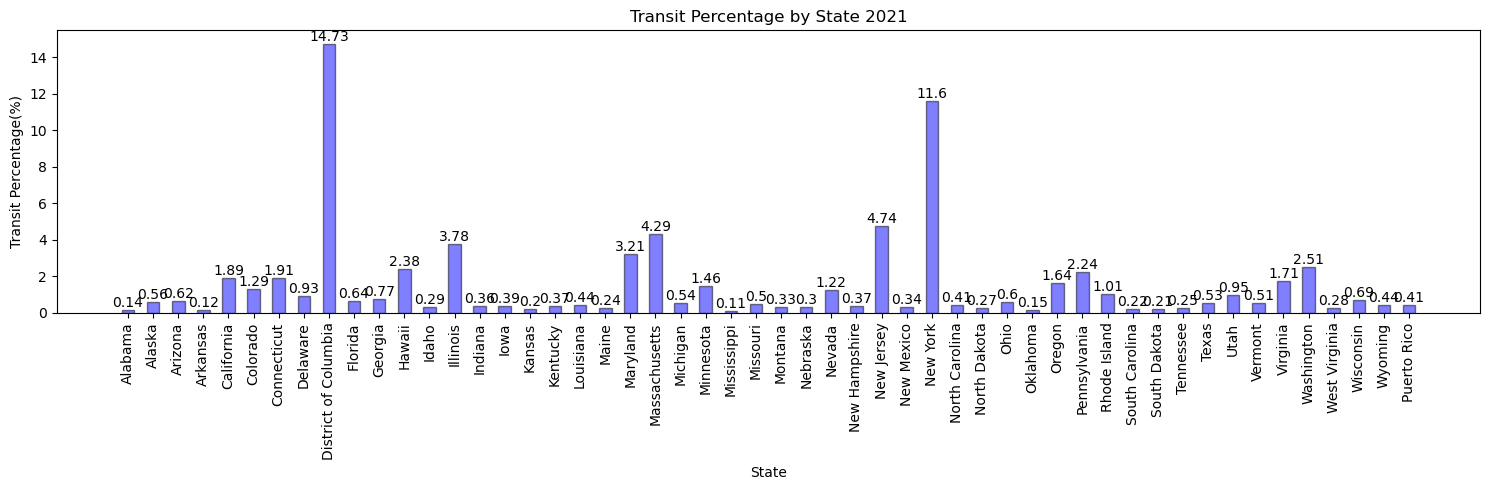

In [132]:
#plot the transit percentage by State
plt.figure(figsize=(15, 5))
plt.bar(merged_df['State'], merged_df['Transit Percentage(%)'], color='b', alpha=0.5, align="center", width=0.5, edgecolor='black')
plt.xticks(rotation=90)
plt.title("Transit Percentage by State 2021")
plt.xlabel("State")
plt.ylabel("Transit Percentage(%)")
plt.tight_layout()

#make number tags on top of each bar
for index, value in enumerate(merged_df['Transit Percentage(%)']):
    plt.text(index, value, str(round(value, 2)), horizontalalignment='center', verticalalignment='bottom')

#make the plot look better
plt.tight_layout()
plt.savefig("figs/Transit Percentage by State 2021.png")
plt.show()

In [133]:
#DF 2021
year = 2021 
values_to_drop = ['United States', 'New York', 'Puerto Rico']
clean_df = clean_df.drop(clean_df[clean_df['State'].isin(values_to_drop)].index)
df_year_2 = clean_df[clean_df['Year'] == year]
grouped_2 = df_year_2.groupby('State')['COVID-19 Deaths'].sum()
df_grouped_2 = pd.DataFrame({'State': grouped_2.index, 'COVID-19 Deaths': grouped_2.values})
df_grouped_2 = df_grouped_2.sort_values('COVID-19 Deaths', ascending = False)

df_grouped_2.head()

,State,COVID-19 Deaths
4,California,202929
43,Texas,188130
9,Florida,145836
38,Pennsylvania,76078
35,Ohio,73934


In [134]:
#merge the df_grouped_2 and the census_data_population on state
percentage_death = pd.merge(df_grouped_2, census_data_population, how = "right", on="State")
percentage_death=percentage_death.drop(columns=['state'])
percentage_death.head()

#calculate the percentage of death using covid-19 deaths/population
percentage_death['Percentage of Death(%)'] = (percentage_death['COVID-19 Deaths']/percentage_death['Population'])*100

#drop the nan values
percentage_death = percentage_death.dropna()

percentage_death.head()

,State,COVID-19 Deaths,Population,Percentage of Death(%)
0,Alabama,29628.0,4997675.0,0.592836
1,Alaska,1259.0,735951.0,0.171071
2,Arizona,49638.0,7079203.0,0.701181
3,Arkansas,16886.0,3006309.0,0.561685
4,California,202929.0,39455353.0,0.514326


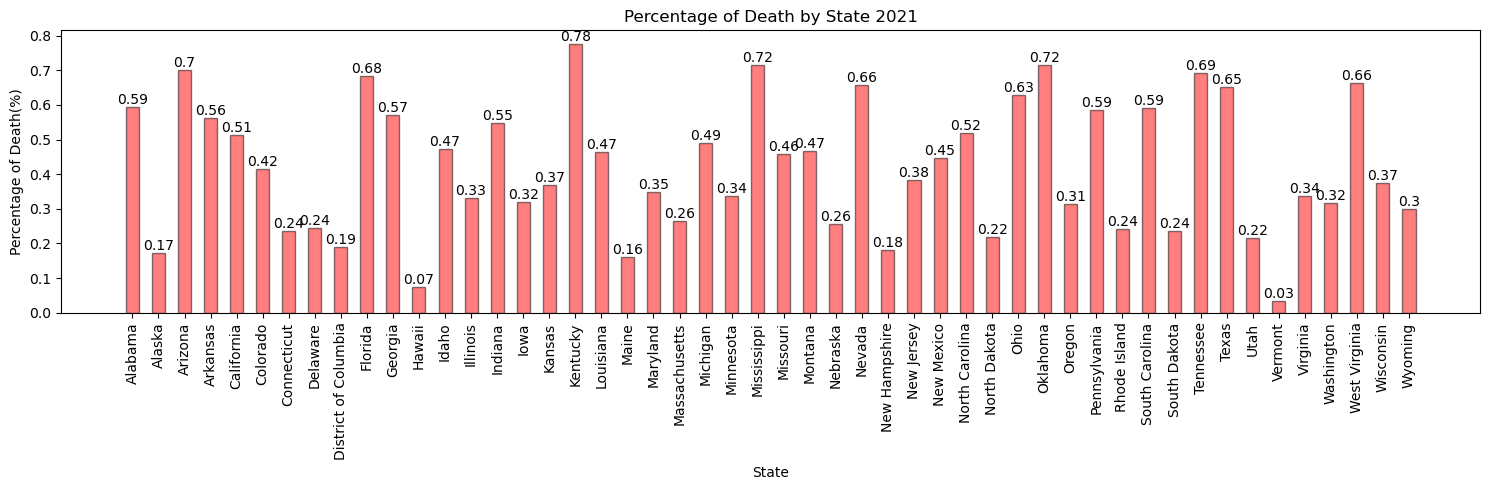

In [135]:
#plot the percentage of death by state
plt.figure(figsize=(15, 5))
plt.bar(percentage_death['State'], percentage_death['Percentage of Death(%)'], color='r', alpha=0.5, align="center", width=0.5, edgecolor='black')
plt.xticks(rotation=90)
plt.title("Percentage of Death by State 2021")
plt.xlabel("State")
plt.ylabel("Percentage of Death(%)")
plt.tight_layout()

#make number tags on top of each bar
for index, value in enumerate(percentage_death['Percentage of Death(%)']):
    plt.text(index, value, str(round(value, 2)), horizontalalignment='center', verticalalignment='bottom')

#make the plot look better
plt.tight_layout()
plt.savefig("figs/Percentage of Death by State 2021.png")
plt.show()

In [136]:
#combine the transit percentage and the percentage of death into a new dataframe
transit_percentage_death = pd.merge(merged_df, percentage_death, how = "right", on="State")
transit_percentage_death=transit_percentage_death.drop(columns=['Population_y','Population_x','COVID-19 Deaths','Transit', 'COVID-19 Deaths'])
#drop the nan values
transit_percentage_death = transit_percentage_death.dropna()

transit_percentage_death.head()

,State,Transit Percentage(%),Percentage of Death(%)
0,Alabama,0.142006,0.592836
1,Alaska,0.562402,0.171071
2,Arizona,0.622062,0.701181
3,Arkansas,0.124671,0.561685
4,California,1.885209,0.514326


The correlation between both factors is -0.28


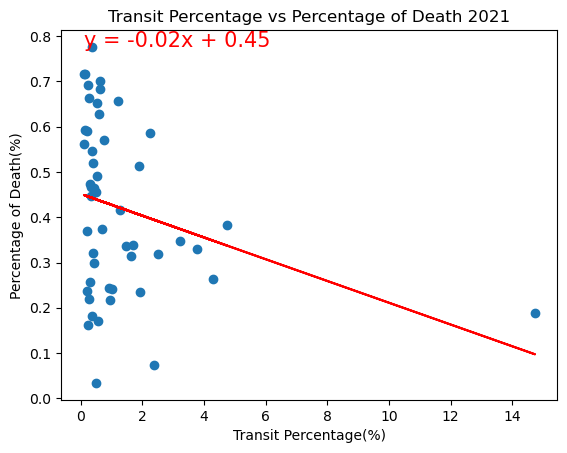

In [137]:
#establish the correlation between transit percentage and percentage of death
correlation = st.pearsonr(transit_percentage_death['Transit Percentage(%)'], transit_percentage_death['Percentage of Death(%)'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

#calulate the linear regression
x_values = transit_percentage_death['Transit Percentage(%)']
y_values = transit_percentage_death['Percentage of Death(%)']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))



plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")


#add the equation and line to plot
plt.annotate(line_eq, (min(x_values), max(y_values)), fontsize=15, color="red")
plt.title('Transit Percentage vs Percentage of Death 2021')
plt.xlabel('Transit Percentage(%)')
plt.ylabel('Percentage of Death(%)')
plt.savefig("figs/Transit Percentage vs Percentage of Death 2021.png")
plt.show()

In [138]:
# Group Covid-19 deaths by year and month while keeping months in order
grouped_df = clean_df.groupby(['Year', 'Month'])['COVID-19 Deaths'].sum().reset_index()
grouped_df.sort_values(by=['Year', 'Month'])


# Group into seasons by defining a function to return the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"
# Apply the function to the dataframe and create a new column named "Season"    
grouped_df['Season'] = grouped_df['Month'].apply(get_season)

# Group the dataframe by year and season and sum the covid-19 deaths
covid_seasons = grouped_df.groupby(['Year', 'Season'])['COVID-19 Deaths'].sum().reset_index()

# Sort the dataframe by year and season for looping purposes
covid_seasons = covid_seasons.sort_values(by=['Year','Season'], ascending= False)


In [139]:
# Create a function to rename the seasons to include the year for plotting legend
def rename_seasons(season):
       season += [''] * (4 - len(season))
       return [f'{s} {year}' for s in season]

# Create a dictionary to store the seasons and years       
covid_years = covid_seasons['Year'].unique()
season_year = {}

# Loop through the years and seasons to rename the seasons
for year in covid_years:
    seasons = covid_seasons.loc[covid_seasons['Year'] == year, 'Season'].tolist()
    season_year[year] = rename_seasons(seasons)

# Loop through the years and seasons to rename the seasons in the dataframe
for year in covid_years:
    for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall']):
        covid_seasons.loc[(covid_seasons['Year'] == year) & (covid_seasons['Season'] == season), 'Season'] = season_year[year][i]
        covid_seasons.pivot(index='Year', columns='Season', values='COVID-19 Deaths')


# Sort the dataframe by year and season for plotting purposes

#covid_seasons = covid_seasons.sort_values(by=['Year','Season'], ascending= True)
index_list = [3,2,1,0,7,6,5,4,11,10,9,8,13,12]
covid_seasons = covid_seasons.reindex(index_list)
covid_seasons


,Year,Season,COVID-19 Deaths
3,2020,Winter 2020,348800
2,2020,Spring 2020,265433
1,2020,Summer 2020,325183
0,2020,Fall 2020,330252
7,2021,Winter 2021,704450
6,2021,Spring 2021,220479
5,2021,Summer 2021,176615
4,2021,Fall 2021,483672
11,2022,Winter 2022,533370
10,2022,Spring 2022,108550


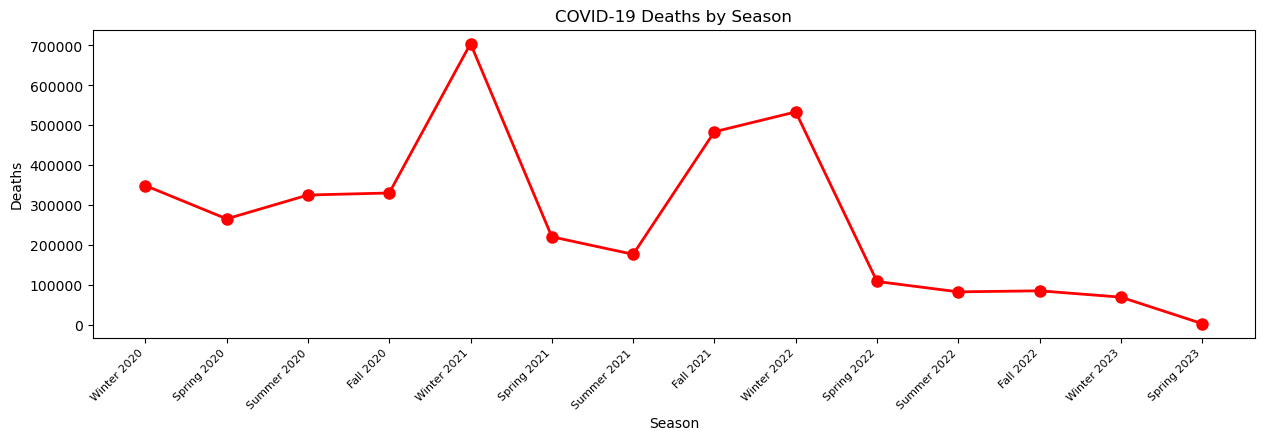

In [140]:
# Create a Line Graph to show the number of COVID-19 deaths by season
# Plot the data
plt.figure(figsize=(15, 4))          
plt.plot(covid_seasons['Season'], covid_seasons['COVID-19 Deaths'], color='red', marker='o', linewidth=2, markersize=8)
plt.gca().set_xticks(covid_seasons['Season'])
plt.gca().set_xticklabels(covid_seasons['Season'], rotation=45, ha='right', fontsize=8)
plt.title('COVID-19 Deaths by Season')
plt.xlabel('Season')
plt.ylabel('Deaths')

# Show the plot
plt.savefig("figs/COVID-19 Deaths by Season.png")
plt.show()

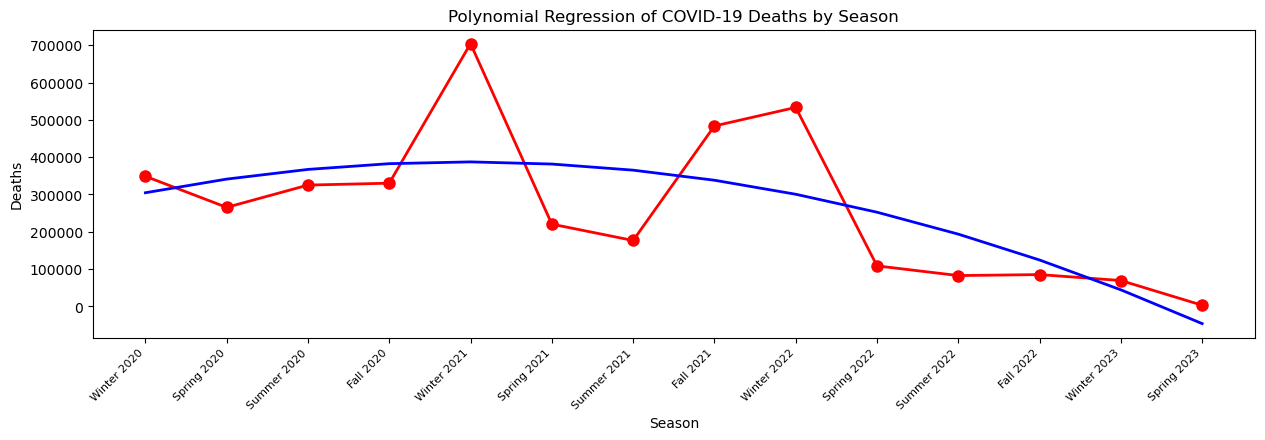

In [141]:
# Polynomial Regression
# Create a dictionary to map the seasons to integers
season_dict = {'Winter 2020': 1,
               'Spring 2020': 2,
               'Summer 2020': 3,
               'Fall 2020': 4,
               'Winter 2021': 5,
               'Spring 2021': 6,
               'Summer 2021': 7,
               'Fall 2021': 8,
               'Winter 2022': 9,
               'Spring 2022': 10,
               'Summer 2022': 11,
               'Fall 2022': 12,
               'Winter 2023': 13,
               'Spring 2023': 14,}

# Create a list of the seasons and a list of the deaths
season = covid_seasons['Season']
deaths = covid_seasons['COVID-19 Deaths']

# Convert the seasons to integers
season_integer = [season_dict[s] for s in season]

# Create the polynomial regression model
poly = PolynomialFeatures(degree=2)
season_poly = poly.fit_transform(np.array(season_integer).reshape(-1, 1))
model = LinearRegression()
model.fit(season_poly, deaths)

# Plot the data
plt.figure(figsize=(15, 4))
plt.plot(covid_seasons['Season'], deaths, color='red', marker='o',linewidth=2, markersize=8)
plt.plot(covid_seasons['Season'], model.predict(season_poly), color='blue', linewidth=2)
plt.gca().set_xticks(covid_seasons['Season'])
plt.gca().set_xticklabels(covid_seasons['Season'], rotation=45, ha='right', fontsize=8)
plt.title('Polynomial Regression of COVID-19 Deaths by Season')
plt.xlabel('Season')
plt.ylabel('Deaths')

# Show the plot
plt.savefig("figs/Polynomial Regression of COVID-19 Deaths by Season.png")
plt.show()

In [142]:
# Group Covid-19 deaths by year and month while keeping months in order
grouped_df = clean_df.groupby(['Year', 'Month', 'Condition Group', 'Condition'])['COVID-19 Deaths'].sum().reset_index()
grouped_df.sort_values(by=['Year', 'Month'])


# Group into seasons by defining a function to return the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
# Apply the function to the dataframe and create a new column named "Season"    
grouped_df['Season'] = grouped_df['Month'].apply(get_season)

# Only keep the rows where the COVID-19 Deaths is not 0
grouped_df = grouped_df[grouped_df['COVID-19 Deaths'] != 0]

# Group the data by year, season, and condition
condition_df = grouped_df.groupby(['Year', 'Season', 'Condition'])['COVID-19 Deaths'].sum().reset_index()

# Group the data by year, season, and condition group
condition_group_df = grouped_df.groupby(['Year', 'Season', 'Condition Group'])['COVID-19 Deaths'].sum().reset_index()


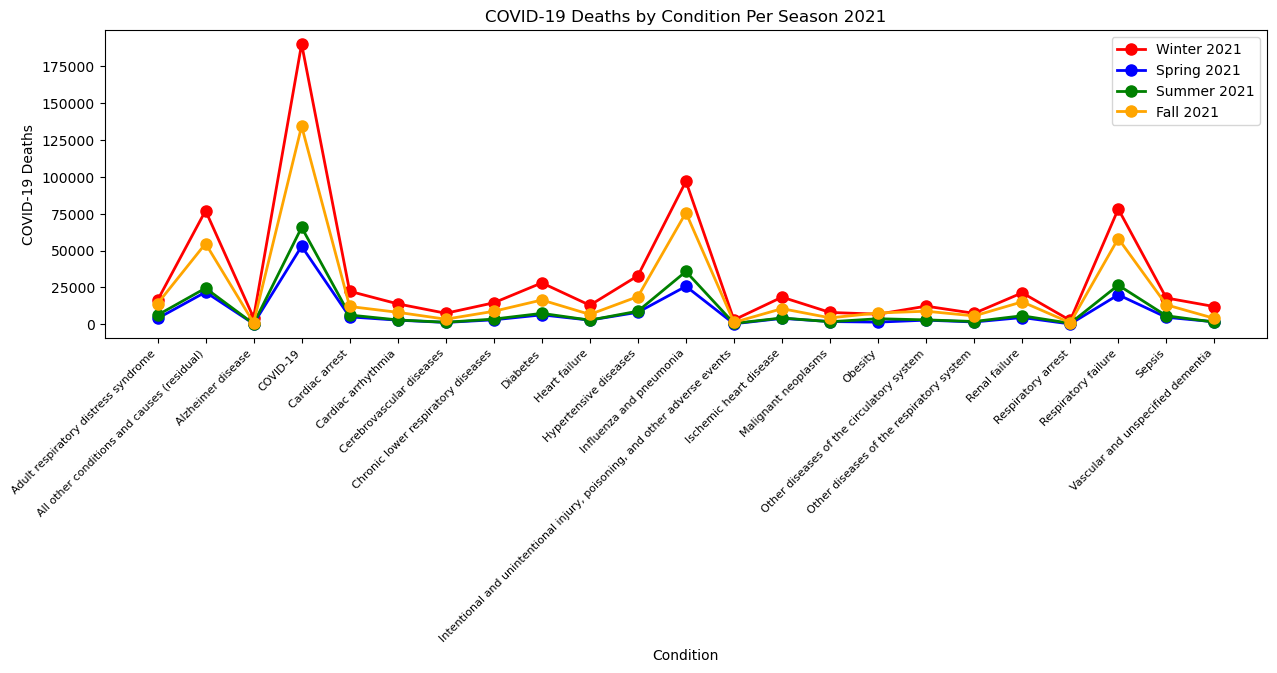

In [143]:

# Create a Line Graph to show the number of COVID-19 deaths by season and condition for 2021
condition2021 = condition_df[condition_df['Year'] == 2021]

# Create a list of the seasons and a list of the deaths for each season
x1 = condition2021[condition2021['Season'] == 'Winter']['Condition']
y1 = condition2021[condition2021['Season'] == 'Winter']['COVID-19 Deaths']
x2 = condition2021[condition2021['Season'] == 'Spring']['Condition']
y2 = condition2021[condition2021['Season'] == 'Spring']['COVID-19 Deaths']
x3 = condition2021[condition2021['Season'] == 'Summer']['Condition']
y3 = condition2021[condition2021['Season'] == 'Summer']['COVID-19 Deaths']
x4 = condition2021[condition2021['Season'] == 'Fall']['Condition']
y4 = condition2021[condition2021['Season'] == 'Fall']['COVID-19 Deaths']

# Plot the data
plt.figure(figsize=(15, 4))
plt.plot(x1, y1, color='red', marker='o', linewidth=2, markersize=8)
plt.plot(x2, y2, color='blue', marker='o', linewidth=2, markersize=8)
plt.plot(x3, y3, color='green', marker='o', linewidth=2, markersize=8)
plt.plot(x4, y4, color='orange', marker='o', linewidth=2, markersize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title('COVID-19 Deaths by Condition Per Season 2021')
plt.xlabel('Condition')
plt.ylabel('COVID-19 Deaths')
plt.legend(['Winter 2021', 'Spring 2021', 'Summer 2021', 'Fall 2021'])

# Show the plot
plt.savefig("figs/COVID-19 Deaths by Condition Per Season 2021.png")
plt.show()


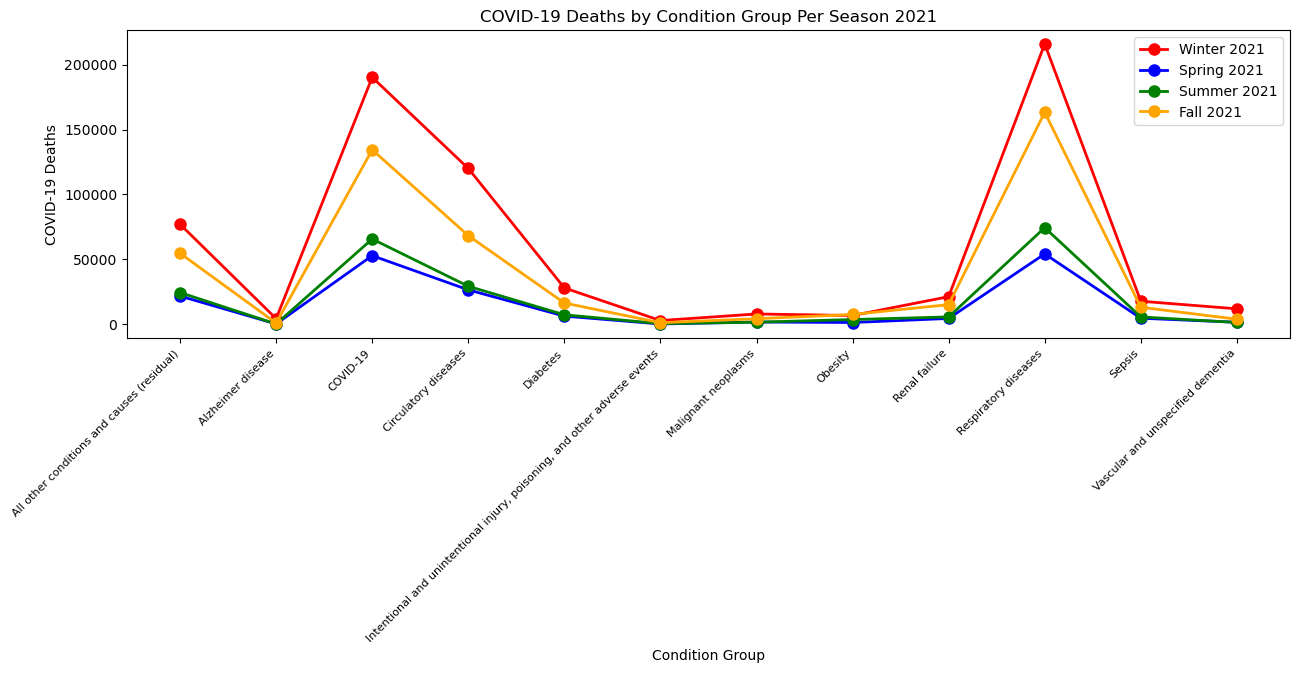

In [144]:
# Create a Line Graph to show the number of COVID-19 deaths by season and condition group for 2021
condition_group2021 = condition_group_df[condition_group_df['Year'] == 2021]

# Create a list of the seasons and a list of the deaths for each season
x1 = condition_group2021[condition_group2021['Season'] == 'Winter']['Condition Group']
y1 = condition_group2021[condition_group2021['Season'] == 'Winter']['COVID-19 Deaths']
x2 = condition_group2021[condition_group2021['Season'] == 'Spring']['Condition Group']
y2 = condition_group2021[condition_group2021['Season'] == 'Spring']['COVID-19 Deaths']
x3 = condition_group2021[condition_group2021['Season'] == 'Summer']['Condition Group']
y3 = condition_group2021[condition_group2021['Season'] == 'Summer']['COVID-19 Deaths']
x4 = condition_group2021[condition_group2021['Season'] == 'Fall']['Condition Group']
y4 = condition_group2021[condition_group2021['Season'] == 'Fall']['COVID-19 Deaths']

# Plot the data
plt.figure(figsize=(15, 4))
plt.plot(x1, y1, color='red', marker='o', linewidth=2, markersize=8)
plt.plot(x2, y2, color='blue', marker='o', linewidth=2, markersize=8)
plt.plot(x3, y3, color='green', marker='o', linewidth=2, markersize=8)
plt.plot(x4, y4, color='orange', marker='o', linewidth=2, markersize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title('COVID-19 Deaths by Condition Group Per Season 2021')
plt.xlabel('Condition Group')
plt.ylabel('COVID-19 Deaths')
plt.legend(['Winter 2021', 'Spring 2021', 'Summer 2021', 'Fall 2021'])

# Show the plot
plt.savefig("figs/COVID-19 Deaths by Condition Group Per Season 2021.png")
plt.show()

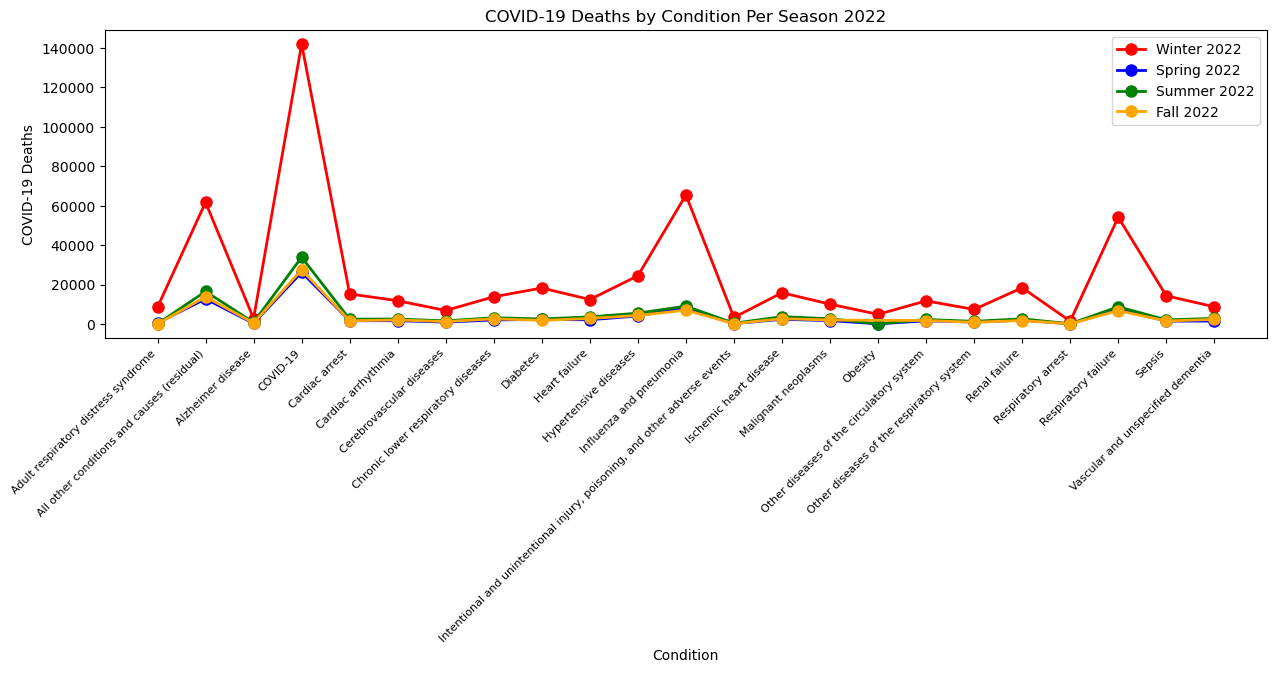

In [145]:
# Create a Line Graph to show the number of COVID-19 deaths by season and condition for 2022
condition2022 = condition_df[condition_df['Year'] == 2022]

# Create a list of the seasons and a list of the deaths for each season
x1 = condition2022[condition2022['Season'] == 'Winter']['Condition']
y1 = condition2022[condition2022['Season'] == 'Winter']['COVID-19 Deaths']
x2 = condition2022[condition2022['Season'] == 'Spring']['Condition']
y2 = condition2022[condition2022['Season'] == 'Spring']['COVID-19 Deaths']
x3 = condition2022[condition2022['Season'] == 'Summer']['Condition']
y3 = condition2022[condition2022['Season'] == 'Summer']['COVID-19 Deaths']
x4 = condition2022[condition2022['Season'] == 'Fall']['Condition']
y4 = condition2022[condition2022['Season'] == 'Fall']['COVID-19 Deaths']

# Plot the data
plt.figure(figsize=(15, 4))
plt.plot(x1, y1, color='red', marker='o', linewidth=2, markersize=8)
plt.plot(x2, y2, color='blue', marker='o', linewidth=2, markersize=8)
plt.plot(x3, y3, color='green', marker='o', linewidth=2, markersize=8)
plt.plot(x4, y4, color='orange', marker='o', linewidth=2, markersize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title('COVID-19 Deaths by Condition Per Season 2022')
plt.xlabel('Condition')
plt.ylabel('COVID-19 Deaths')
plt.legend(['Winter 2022', 'Spring 2022', 'Summer 2022', 'Fall 2022'])

# Show the plot
plt.savefig("figs/COVID-19 Deaths by Condition Per Season 2022.png")
plt.show()

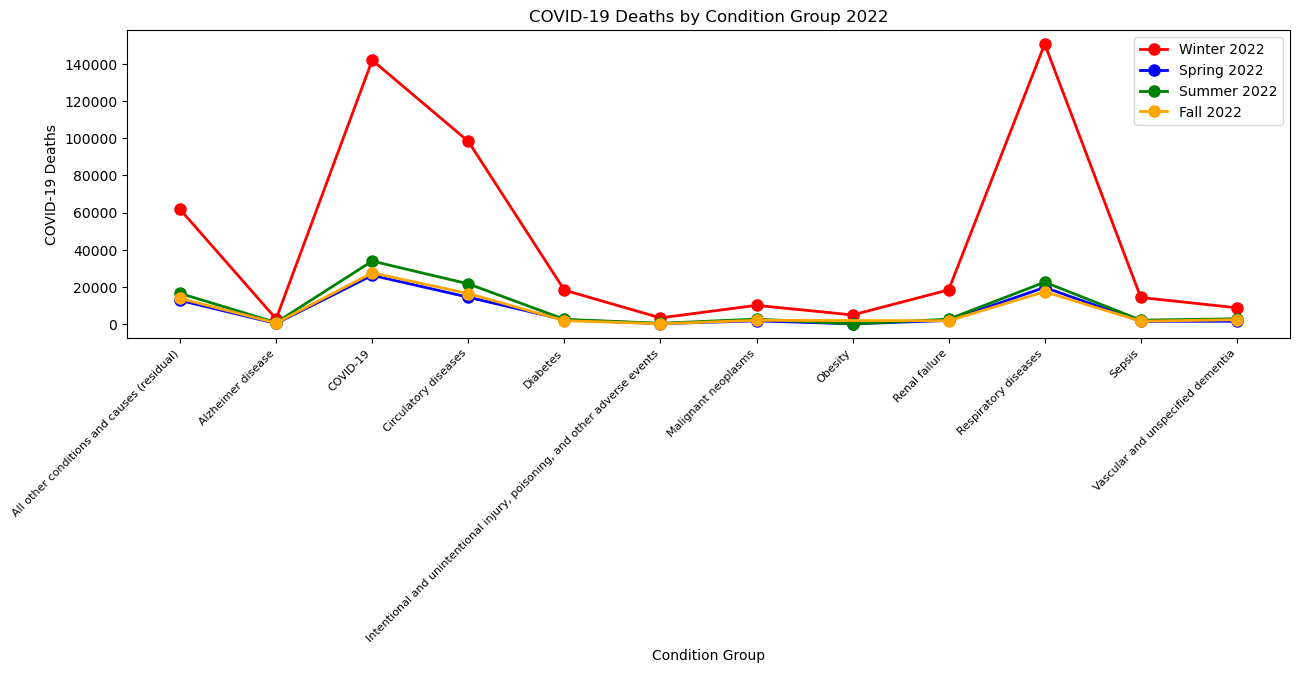

In [146]:
# Create a Line Graph to show the number of COVID-19 deaths by season and condition group for 2022
condition_group2022 = condition_group_df[condition_group_df['Year'] == 2022]

# Create a list of the seasons and a list of the deaths for each season
x1 = condition_group2022[condition_group2022['Season'] == 'Winter']['Condition Group']
y1 = condition_group2022[condition_group2022['Season'] == 'Winter']['COVID-19 Deaths']
x2 = condition_group2022[condition_group2022['Season'] == 'Spring']['Condition Group']
y2 = condition_group2022[condition_group2022['Season'] == 'Spring']['COVID-19 Deaths']
x3 = condition_group2022[condition_group2022['Season'] == 'Summer']['Condition Group']
y3 = condition_group2022[condition_group2022['Season'] == 'Summer']['COVID-19 Deaths']
x4 = condition_group2022[condition_group2022['Season'] == 'Fall']['Condition Group']
y4 = condition_group2022[condition_group2022['Season'] == 'Fall']['COVID-19 Deaths']

# Plot the data
plt.figure(figsize=(15, 4))
plt.plot(x1, y1, color='red', marker='o', linewidth=2, markersize=8)
plt.plot(x2, y2, color='blue', marker='o', linewidth=2, markersize=8)
plt.plot(x3, y3, color='green', marker='o', linewidth=2, markersize=8)
plt.plot(x4, y4, color='orange', marker='o', linewidth=2, markersize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title('COVID-19 Deaths by Condition Group 2022')
plt.xlabel('Condition Group')
plt.ylabel('COVID-19 Deaths')
plt.legend(['Winter 2022', 'Spring 2022', 'Summer 2022', 'Fall 2022'])

# Show the plot
plt.savefig("figs/COVID-19 Deaths by Condition Group Per Season 2022.png")
plt.show()

In [185]:
region_map = {
    'Alabama': 'Southeast',
    'Alaska': 'Northwest',
    'Arizona': 'Southwest',
    'Arkansas': 'Southeast',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'Northwest',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'Southeast',
    'Louisiana': 'Southeast',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'Southeast',
    'Missouri': 'Midwest',
    'Montana': 'Northwest',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'Southwest',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'Southwest',
    'Oregon': 'Northwest',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'Southeast',
    'Texas': 'Southwest',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'Northwest',
    'West Virginia': 'Southeast',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West',
}

# New column state to region
clean_df['region'] = clean_df['State'].map(region_map)

# Group data into region and count deaths
grouped_data_2 = clean_df.loc[clean_df['Year'] == 2021].groupby(['region','Month', 'Year'])['COVID-19 Deaths'].count()
grouped_data_3 = clean_df.loc[clean_df['Year'] == 2022].groupby(['region','Month', 'Year'])['COVID-19 Deaths'].count()

grouped_data_2 = grouped_data_2.reset_index()
grouped_data_3 = grouped_data_3.reset_index()

grouped_data_2 = grouped_data_2.rename(columns={'COVID-19 Deaths': 'Deaths'})
grouped_data_3 = grouped_data_3.rename(columns={'COVID-19 Deaths': 'Deaths'})

grouped_data_3

,region,Month,Year,Deaths
0,Midwest,1,2022,1720
1,Midwest,2,2022,1615
2,Midwest,3,2022,1491
3,Midwest,4,2022,1559
4,Midwest,5,2022,1608
...,...,...,...,...
67,West,8,2022,819
68,West,9,2022,860
69,West,10,2022,890
70,West,11,2022,812


In [177]:
# Group Covid-19 deaths by year and month while keeping months in order

grouped_data_2.sort_values(by=['Year', 'Month', 'region'])


# Group into seasons by defining a function to return the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
# Apply the function to the dataframe and create a new column named "Season"    
grouped_data_2['Season'] = grouped_data_2['Month'].apply(get_season)

# Only keep the rows where the COVID-19 Deaths is not 0
grouped_data_2 = grouped_data_2[grouped_data_2['Deaths'] != 0]

# Group the data by year, season, and condition
condition_data_2 = grouped_data_2.groupby(['Year', 'Season', 'region'])['Deaths'].sum().reset_index()



,Year,region,Deaths
0,2021,Midwest,5012
1,2021,Northeast,4220
2,2021,Northwest,2009
3,2021,Southeast,5067
4,2021,Southwest,1729
5,2021,West,2566


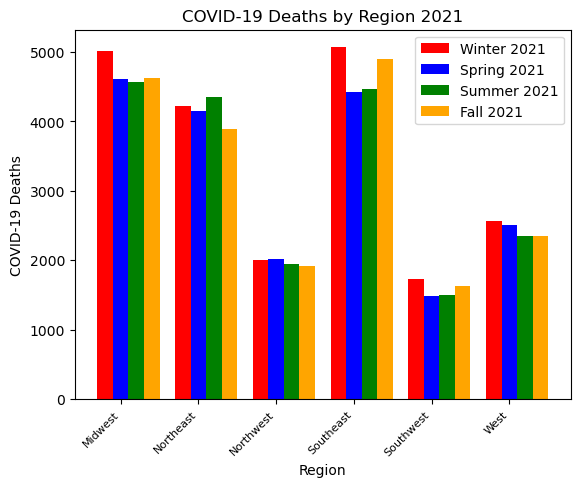

In [190]:
winter2021 = condition_data_2[condition_data_2['Season'] == 'Winter']

spring2021 = condition_data_2[condition_data_2['Season'] == 'Spring']

summer2021 = condition_data_2[condition_data_2['Season'] == 'Summer']

fall2021 = condition_data_2[condition_data_2['Season'] == 'Fall']

x = [winter2021['region'], spring2021['region'], summer2021['region'], fall2021['region']]
y = [winter2021['Deaths'], spring2021['Deaths'], summer2021['Deaths'], fall2021['Deaths']]

bar_width = 0.2
shift = [-bar_width, 0, bar_width, 2*bar_width]


colors = ['red', 'blue', 'green', 'orange']
labels = ['Winter 2021', 'Spring 2021', 'Summer 2021', 'Fall 2021']
for i in range(4):
    plt.bar(np.arange(len(x[i])) + shift[i], y[i], width=bar_width, color=colors[i], label=labels[i])
    plt.xticks(np.arange(len(x[i])), x[i], rotation=45, ha='right', fontsize=8)
    plt.title('COVID-19 Deaths by Region 2021')
    plt.xlabel('Region')
    plt.ylabel('COVID-19 Deaths')
    plt.legend()
    
    
plt.savefig('figs/covid_deaths_by_region_2021.png')


In [186]:
# Group Covid-19 deaths by year and month while keeping months in order

grouped_data_3.sort_values(by=['Year', 'Month', 'region'])


# Group into seasons by defining a function to return the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
# Apply the function to the dataframe and create a new column named "Season"    
grouped_data_3['Season'] = grouped_data_3['Month'].apply(get_season)

# Only keep the rows where the COVID-19 Deaths is not 0
grouped_data_3 = grouped_data_3[grouped_data_3['Deaths'] != 0]

# Group the data by year, season, and condition
condition_data_3 = grouped_data_3.groupby(['Year', 'Season', 'region'])['Deaths'].sum().reset_index()

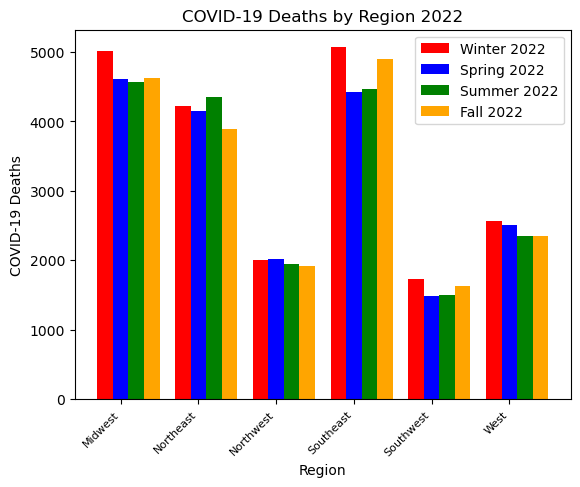

In [191]:
winter2022 = condition_data_2[condition_data_2['Season'] == 'Winter']

spring2022 = condition_data_2[condition_data_2['Season'] == 'Spring']

summer2022 = condition_data_2[condition_data_2['Season'] == 'Summer']

fall2022 = condition_data_2[condition_data_2['Season'] == 'Fall']

x = [winter2022['region'], spring2022['region'], summer2022['region'], fall2022['region']]
y = [winter2022['Deaths'], spring2022['Deaths'], summer2022['Deaths'], fall2022['Deaths']]

bar_width = 0.2
shift = [-bar_width, 0, bar_width, 2*bar_width]


colors = ['red', 'blue', 'green', 'orange']
labels = ['Winter 2022', 'Spring 2022', 'Summer 2022', 'Fall 2022']
for i in range(4):
    plt.bar(np.arange(len(x[i])) + shift[i], y[i], width=bar_width, color=colors[i], label=labels[i])
    plt.xticks(np.arange(len(x[i])), x[i], rotation=45, ha='right', fontsize=8)
    plt.title('COVID-19 Deaths by Region 2022')
    plt.xlabel('Region')
    plt.ylabel('COVID-19 Deaths')
    plt.legend()
    
    
plt.savefig('figs/covid_deaths_by_region_2022.png')